## Environment configuration

In [43]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import sys
from glob import iglob
from os.path import join
from collections import namedtuple
from pylab import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.colorbar import colorbar

mpl.rc('figure', max_open_warning = 0)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

## Define plot extent
We are going to define our plot extent as rectangle that incorporates the Netherlands.

In [3]:
Point = namedtuple('Point', 'lon lat')
bilt_coords = Point(5.1806, 52.11)

extent_length = 10
extent_width = 10
plot_extent = (bilt_coords.lon-extent_width, 
               bilt_coords.lon+extent_width, 
               bilt_coords.lat-extent_length, 
               bilt_coords.lat+extent_length,)

print("Plot extent: lon({}, {}), lat({}, {})".format(*plot_extent))

Plot extent: lon(-4.8194, 15.1806), lat(42.11, 62.11)


## Reading the data

The sample products are usually stored in a structured directory tree. The following line of code recursively looks for all files matching a given filename pattern starting from a root directory.

In [4]:
input_files_dir = "/home/jakolien/Documents/56EO/data/s5p/DeltaNOx/NO2/"
input_files = sorted(list(iglob(join(input_files_dir, '**', '*NO2*.nc'), recursive=True)))

for counter, input_file in enumerate(input_files):
    fields = input_file.split('_')
    print("#{} Orbit: {}, Sensing Start: {}, Sensing Stop: {}".format(counter, fields[10], fields[8], fields[9]))

#0 Orbit: 10826, Sensing Start: 20191115T115014, Sensing Stop: 20191115T115514
#1 Orbit: 10841, Sensing Start: 20191116T131514, Sensing Stop: 20191116T132014
#2 Orbit: 10854, Sensing Start: 20191117T111514, Sensing Stop: 20191117T112014
#3 Orbit: 10869, Sensing Start: 20191118T123514, Sensing Stop: 20191118T124014
#4 Orbit: 10883, Sensing Start: 20191119T121514, Sensing Stop: 20191119T122014
#5 Orbit: 10897, Sensing Start: 20191120T120014, Sensing Stop: 20191120T120514
#6 Orbit: 10911, Sensing Start: 20191121T114014, Sensing Stop: 20191121T114514
#7 Orbit: 10925, Sensing Start: 20191122T112014, Sensing Stop: 20191122T112514
#8 Orbit: 10940, Sensing Start: 20191123T124014, Sensing Stop: 20191123T124514
#9 Orbit: 10954, Sensing Start: 20191124T122454, Sensing Stop: 20191124T122954
#10 Orbit: 10968, Sensing Start: 20191125T120555, Sensing Stop: 20191125T121055
#11 Orbit: 10982, Sensing Start: 20191126T114555, Sensing Stop: 20191126T115055


Open product with xarray:

In [5]:
vars = xr.open_dataset(input_files[0], group='/PRODUCT')
print(vars)

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 0.0 ... 371.0
  * ground_pixel                                          (ground_pixel) float64 0.0 ... 449.0
  * time                                                  (time) datetime64[ns] 2019-11-15
  * corner                                                (corner) float64 0.0 ... 3.0
  * polynomial_exponents                                  (polynomial_exponents) float64 0.0 ... 5.0
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 0.0
  * layer                                                 (layer) float64 0.0 ... 33.0
  * vertices                                              (vertices) float64 0.0 1.0
    latitude       

The variable of interest (NO2 tropospheric column) is stored in the PRODUCT group, so all we have to do is:

In [6]:
no2tc = vars['nitrogendioxide_tropospheric_column']
print(no2tc)

<xarray.DataArray 'nitrogendioxide_tropospheric_column' (time: 1, scanline: 372, ground_pixel: 450)>
[167400 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 3.0 ... 368.0 369.0 370.0 371.0
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2019-11-15
    latitude      (time, scanline, ground_pixel) float32 ...
    longitude     (time, scanline, ground_pixel) float32 ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         troposphere_mole_c...
    long_name:                                             Tropospheric verti...
    ancillary_variables:                                   nitrogendioxide_tr...
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19


The advantage of storing our data into an xarray DataArray is being able to access xarray's amazing indexing, filtering and masking capabilities, something that would require much more effort, should we limited to use the basic NetCDF4 libray instead.

## Processing the data

We would like to subset our dataset around our point of interest. To do so, we are going to define a function that takes an xarray's DataArray and latitude/longitude boundaries, and returns a crop of the input dataset. The function relies on the xarray's filtering function where. Values outside the crop region will be discarded. We assume that both latitude and longitude are actual dimensions in our input dataset.

In [7]:
def subset(no2tc, plot_extent):
    e, w, s, n = plot_extent

    # crop data set around point of interest
    no2tc = no2tc.where(
        (no2tc.longitude > e) &
        (no2tc.longitude < w) &
        (no2tc.latitude > s) & 
        (no2tc.latitude < n), drop=True)

    return no2tc

In [8]:
no2tc = subset(no2tc, plot_extent)

Next, we are going to set all negative values to 0, as well as converting the values to molecules per square cm.

In [9]:
# set all negative values to 0
no2tc = no2tc.where(no2tc > 0, 0)
# convert ALL values to molecules per cm^2
multf = no2tc.multiplication_factor_to_convert_to_molecules_percm2
no2tc = no2tc * multf

## Plotting the data

Let's define a custom color map, with increasing alpha (transparency) level. The idea is that lower values should be more transparent than higher values, following a square root law. Doing so, we prevent lower background values to show up in the plot, and at the same time we emphasize the impact of higher values.

In [10]:
cm_values = np.linspace(0, 1, 16536)
# use the Yellow Orange Brown color map as reference
alpha_cm = plt.cm.YlOrBr(cm_values)
# change alpha value to follow a square low
alpha_cm[:, -1] = np.sqrt(cm_values)
# build new color map
my_cmap = colors.ListedColormap(alpha_cm)

Extract the date of the input file:

In [11]:
def get_date(input_file):
    # extract sensing date
    fields = input_file.split('_')
    day = fields[8][6:8]
    month = fields[8][4:6]
    year = fields[8][0:4]
    
    date = day + month + year
    
    return date

For sake of convenience, we can define a function that is going to take care of plotting the dataset. We are going to use cartopy's ability to seamlessly add Natural Earth Data features to the plot. In this example, we are going to add state/province borders and land features.

In [45]:
def plot_no2(no2tc):
    
    ax = plt.axes(projection=ccrs.PlateCarree())

    # define Natural Earth features
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor='none',
        linewidth = 1)

    land_10m = cfeature.NaturalEarthFeature(
        category='physical', 
        name='land', 
        scale='10m',
        edgecolor='black',
        linewidth = 1,
        facecolor=cfeature.COLORS['land'])

    # set map background and features
    ax.add_feature(land_10m)
    ax.add_feature(states_provinces, edgecolor='black')
    
    # remove default title
    ax.set_title('')

    # define plot title
    t = r"NO$_2$ tropospheric column"
    ax.text(0, 1.05, t, fontsize=18, transform=ax.transAxes)
    
    # define caption
    ax.text(0.57, -0.1, r"Data: ESA Sentinel-5P/TROPOMI, Map: Natural Earth Data", 
            fontsize=12, color='gray', transform=ax.transAxes)

    # set plot frame color
    ax.outline_patch.set_edgecolor('lightgray')

    # define plot extent
    ax.set_extent(plot_extent, ccrs.PlateCarree()) 

    # set gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # plot data
    try:        
        im = no2tc.isel(time=0).plot.pcolormesh(ax=ax, 
                                                transform=ccrs.PlateCarree(),
                                                infer_intervals=True,
                                                cmap=my_cmap,
                                                norm=colors.PowerNorm(gamma=1./2.),
                                                vmin=0,
                                                vmax=6E16,
                                                x='longitude', 
                                                y='latitude', 
                                                zorder=2)
        # remove side colorbar
        im.colorbar.remove()      

        # set colorbar properties
        cbar = plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)  
        cbar.set_label(r"NO$_2$ (mol per cm$^2$)", labelpad=-70, fontsize=14)
        cbar.outline.set_visible(False)
   
    except IndexError as e:
        print(e)
                   
    return im

In [59]:
def plot_no2_at_date(n):    
    
    # get data set
    no2tc = xr.open_dataset(input_files[n], group='/PRODUCT')['nitrogendioxide_tropospheric_column']
    
    # crop data set around point of interest
    no2tc = subset(no2tc, plot_extent)
    
    # set all negative values to 0
    no2tc = no2tc.where(no2tc > 0, 0)
    
    # convert ALL values to molecules per cm^2
    no2tc = no2tc * no2tc.multiplication_factor_to_convert_to_molecules_percm2

    # plot data
    fig, ax = plt.subplots(figsize=(12, 12))
    plot_no2(no2tc)

    # get sensing date
    date = get_date(input_files[0])

    # save figure
    plt.savefig("DeltaNO2_" + date + ".png", dpi=300, facecolor='w', edgecolor='w',
    orientation='landscape', papertype=None, format=None,
    transparent=False, bbox_inches=None, pad_inches=2,
    frameon=None)

    # show figure
    plt.show()

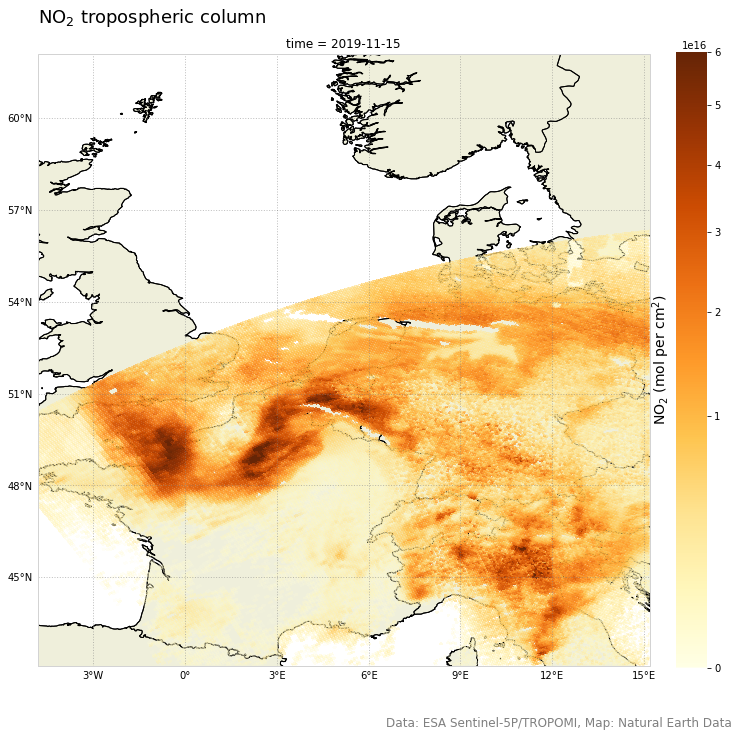

In [60]:
plot_no2_at_date(0)

## Make a movie

We will plot the data day by day over the period of a week.

In [56]:
def plot_no2_over_time(n,ax):
    
    # clear axes
    ax.clear()
    
    # get data set
    no2tc = xr.open_dataset(input_files[n], group='/PRODUCT')['nitrogendioxide_tropospheric_column']
    
    # crop data set around point of interest
    no2tc = subset(no2tc, plot_extent)
    
    # set all negative values to 0
    no2tc = no2tc.where(no2tc > 0, 0)
    
    # convert ALL values to molecules per cm^2
    no2tc = no2tc * no2tc.multiplication_factor_to_convert_to_molecules_percm2
    
    # plot data
    return plot_no2(no2tc)
    
    

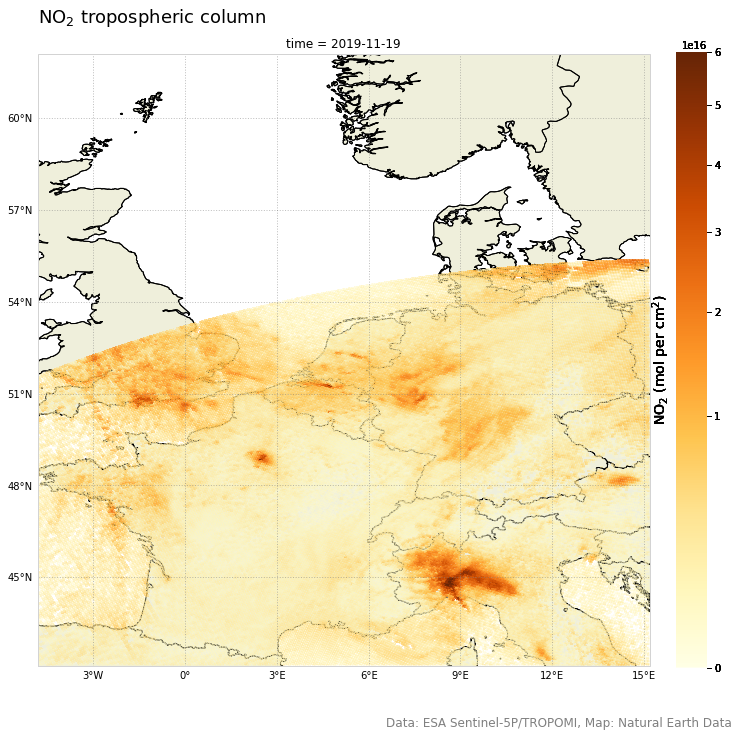

In [61]:
def ani_frame():
    
    fig, ax = plt.subplots(figsize=(12, 12))

    ax = plt.axes(projection=ccrs.PlateCarree())

    # set plot function:  
    def animate(i):
        im = plot_no2_over_time(i,ax)  
        return im,
       
    # make animation:
    ani = animation.FuncAnimation(fig, 
                                  animate,
                                  frames=[0,1,2,3,4],
                                  interval=500,
                                  repeat=False,
                                  blit=True)
                                  #cache_frame_data=True)
    
    # save animation:
    ani.save('no2_data.gif', writer='imagemagick') 
    
test_aniframe = ani_frame()

## Make 3 dimensional Matrix of data

In xarray put NO2 tropospheric column data in matrix form, by adding time axis.

## Use data Google Earth Engine API

For the app we would like to develop we will need to use the NRT NO2 data of the Sentinel 5p satellite. To do so, we make use of the Python API of GEE, and access the most recent data immediately without having to download it first in a local directory.

In [ ]:
## Import the Earth Engine Python Package
import ee

# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()

# get geometric data
country_names = ["Netherlands"];
# import the country feature collection
countries = ee.FeatureCollection('ft:1tdSwUL7MVpOauSgRzqVTOwdfy17KDbw-1d9omPw');
# find the countries in the country list
country = countries.filter(ee.Filter.inList('Country', country_names));

# Print the information for NO2 image collection.
no2ic = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2') \
    .select('tropospheric_NO2_column_number_density') \
    .filterDate('2019-11-22', '2019-11-26') \
    .filterBounds(country);

In [ ]:
print(no2ic.getInfo())

Find the mean value of the image collection at a central location or in the Netherlands, this returns a dictionary of the mean values.

In [ ]:
geom = country.geometry() # ee.Geometry.Point([5.1806, 52.11])  # 

def eeAlgo(image):
    reduced = image.reduceRegion(geometry=geom, reducer=ee.Reducer.mean(), scale=30, maxPixels = 1e9)
    image = image.set('mean', reduced)

    return image

vals = no2ic.map(algorithm=eeAlgo)

#print(vals.getInfo())
#print(vals.aggregate_array('PRODUCT_QUALITY').getInfo())
#print(vals.aggregate_array('system:footprint').getInfo())

mean_no2 = vals.aggregate_array('mean').getInfo()

# Multiply every value in mean_no2 by multiplication factor for molecules per cm^2   
for i in mean_no2: 
    for key in i:
        if i[key] != None:
            i[key] *=  multf
            print(i[key])


In [ ]:
from operator import add

#Load MODIS EVI imagery.
collection = ee.ImageCollection('MODIS/006/MYD13A1').select('EVI').filterDate('2011-01-01','2014-12-31')

#Define reference conditions from the first 10 years of data.
reference = collection.filterDate('2001-01-01','2010-12-31').sort('system:time_start', False)

#Compute the mean of the first 10 years.
mean = reference.mean();

def eeSubtract(image):
    image = image.subtract(mean).set('system:time_start', image.get('system:time_start'))
                                     
    return image
                                    
#Compute anomalies by subtracting the 2001-2010 mean from each image in a
#collection of 2011-2014 images. Copy the date metadata over to the
#computed anomaly images in the new collection.
series = collection.filterDate('2011-01-01','2014-12-31').map(algorithm=eeSubtract)

# Get the timestamp from the most recent image in the reference collection.
time0 = reference.first().get('system:time_start');

#Use imageCollection.iterate() to make a collection of cumulative anomaly over time.
#The initial value for iterate() is a list of anomaly images already processed.
#The first anomaly image in the list is just 0, with the time0 timestamp.
first = ee.List([
  #Rename the first band 'EVI'.
  ee.Image(0).set('system:time_start', time0).select([0], ['EVI'])
]);

#This is a function to pass to Iterate().
#As anomaly images are computed, add them to the list.
def eeAccumulate(image, list):
    #Get the latest cumulative anomaly image from the end of the list with
    #get(-1).  Since the type of the list argument to the function is unknown,
    #it needs to be cast to a List.  Since the return type of get() is unknown,
    #cast it to Image.
    previous = ee.Image(ee.List(list).get(-1));
    #Add the current anomaly to make a new cumulative anomaly image.
    added = image.add(previous).set('system:time_start', image.get('system:time_start'));
    #Return the list with the cumulative anomaly inserted.
    return ee.List(list).add(added);

#Create an ImageCollection of cumulative anomaly images by iterating.
#Since the return type of iterate is unknown, it needs to be cast to a List.
cumulative = ee.ImageCollection(ee.List(series.iterate(eeAccumulate(ee.Image,first))));
